# Exposure

What does "exposure" mean when it comes to Fermi data? The observatory can't point at a specific point of the sky at all times for a certain amount of time in order to get traditional sense of *exposure*. If there was a point source of interest, Fermi may not have been pointing at it at all times of operation. With the solar panel anomaly (see below), the answer to this question becomes more complicated.

This notebook aims to guide users on calculating how much of the sky Fermi obtained data from with a generated exposure map.

# Solar Panel Anomaly

Why should we calculate the exposure for a certain part of the sky? Shouldn't the sky have even coverage?

The [Solar Panel Anomaly](https://fermi.gsfc.nasa.gov/ssc/observations/types/post_anomaly/) page might answer some of these questions.

One of Fermi's solar panel arrays became stuck and was unable to adjust according to the sun's position. This issue posed thermal and power problems for the spacecraft. The proposed solution was to create different profiles for the spacecraft's orbit that varies according the beta angle.

# Survey Profiles

Since the anomaly, Fermi operates in various sky-scanning survey modes. As a result, Fermi's survey mode(s) may drastically impact how much exposure there is on a source.

More information about the types of survey modes can be found in the [LAT All-Sky Survey Observations](https://fermi.gsfc.nasa.gov/ssc/observations/types/allsky/) page, while information on *what* mode Fermi is operating on at a certain time can be found in the [Observatory Timeline](https://fermi.gsfc.nasa.gov/ssc/observations/timeline/posting/).

A handy tool to convert between different time formats is the [**xTime**](http://heasarc.gsfc.nasa.gov/cgi-bin/Tools/xTime/xTime.pl) utility.

We will be calculating the exposure over the entire sky (which requires a weekly file). You may retrieve weekly files of interest, along with their corresponding spacecraft files, in the [FTP Server](https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/photon/).

For this particular example, we will be looking at a certain time interval in Week 559.

![Week 559 Timeline](./img/week559.png "Week 559 Timeline")

In [2]:
!mkdir ./data

In [4]:
!wget -O ./data/photon.fits https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/photon/lat_photon_weekly_w559_p305_v001.fits
!wget -O ./data/spacecraft.fits https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/spacecraft/lat_spacecraft_weekly_w559_p310_v001.fits

--2021-11-30 11:46:57--  https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/photon/lat_photon_weekly_w559_p305_v001.fits
Resolving heasarc.gsfc.nasa.gov (heasarc.gsfc.nasa.gov)... 129.164.179.23
Connecting to heasarc.gsfc.nasa.gov (heasarc.gsfc.nasa.gov)|129.164.179.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148250880 (141M) [application/fits]
Saving to: ‘./data/photon.fits’

./data/photon.fits  100%[===================>] 141.38M  22.7MB/s    in 6.2s    

2021-11-30 11:47:04 (22.9 MB/s) - ‘./data/photon.fits’ saved [148250880/148250880]

--2021-11-30 11:47:04--  https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/spacecraft/lat_spacecraft_weekly_w559_p310_v001.fits
Resolving heasarc.gsfc.nasa.gov (heasarc.gsfc.nasa.gov)... 129.164.179.23
Connecting to heasarc.gsfc.nasa.gov (heasarc.gsfc.nasa.gov)|129.164.179.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2836800 (2.7M) [application/fits]
Saving to: ‘./data/spacecr

In [5]:
from gt_apps import filter
from astropy.io import fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Make selections on the data

We will be using **gtselect** in order to pick out the time interval we want to calculate our exposure for.

Because we are using python, **gtselect** will instead be `filter` and we can see what its parameters are:

In [6]:
filter.pars()

' infile= outfile= ra="INDEF" dec="INDEF" rad="INDEF" tmin="INDEF" tmax="INDEF" emin=30.0 emax=300000.0 zmin=0.0 zmax=180.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"'

It is assumed that the photon events file is called `photon.fits` and is placed in the directory `data` of the current working directory.

The idea is to first pick out our selections and our time interval of interest and create an exposure map for it. For our example, our time interval of interest is, in MET, `571883705` to `571883705+86400`, and we want to see photons of energy 1 GeV. We should note that Fermi was in a [50-degree modified sine profile](https://fermi.gsfc.nasa.gov/ssc/observations/types/allsky/) during this time period.

Run `filter`:

In [7]:
filter['infile'] = './data/photon.fits'
filter['outfile'] = './data/photon_filtered_oneday.fits'
filter['ra'] = 'INDEF'
filter['dec'] = 'INDEF'
filter['rad'] = 'INDEF'
filter['tmin'] = 571883705.000 #in the middle of modified 50 deg sine
filter['tmax'] = 571883705.000+86400.

filter['emin'] = 1000
filter['emax'] = 1000
filter['zmax'] = 100 # Does not matter what this is; we are looking at the whole sky

In [8]:
filter.run()

time -p gtselect infile=./data/photon.fits outfile=./data/photon_filtered_oneday.fits ra="INDEF" dec="INDEF" rad="INDEF" tmin=571883705.0 tmax=571970105.0 emin=1000.0 emax=1000.0 zmin=0.0 zmax=100.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 1.36
user 1.21
sys 0.09


Fermi cannot cover the whole sky in one orbit, or even one day of livetime, with the 50-degree modified sine profile. We need a whole sky map as a reference for us to make a selection on what parts of the sky would have zero photon counts or more than zero photon counts. Without a reference map, we cannot determine how much of the sky is exposed to the LAT with just one exposure map.

Because we need an exposure map that covers the whole sky, let's look at the times where the [+/- 50 degree](https://fermi.gsfc.nasa.gov/ssc/observations/types/allsky/) profile was in place. We pick the +/- 50 degree profile because the LAT obtains a map of the whole sky every two orbits.

According to the timeline, Fermi was in a +/- 50 degree orbit rocking every two orbits between `2019-02-18 23:30:00` to `2019-02-21 00:00:00`. In MET, this is `572225405.000` to `572400005.000`.

Let's take a cut for one day:

In [9]:
filter['tmin'] = 572225405.000 #in +/- 50 deg survey integer orbits from rockstart
filter['tmax'] = 572225405.000 + 86400
filter['outfile'] = './data/photon_filtered_pm50.fits'

In [10]:
filter.run()

time -p gtselect infile=./data/photon.fits outfile=./data/photon_filtered_pm50.fits ra="INDEF" dec="INDEF" rad="INDEF" tmin=572225405.0 tmax=572311805.0 emin=1000.0 emax=1000.0 zmin=0.0 zmax=100.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 1.34
user 1.23
sys 0.09


Both maps are created with the Aitoff projection, which allows each pixel in the resulting exposure maps cover the same area of sky.

# Compute livetimes

The tools that create the exposure maps of interest require us to compute livetimes, so, we compute the livetime cube files using **gtltcube** (`expCube` in python). We do this for both of the filtered data.

In [11]:
from gt_apps import expCube

In [12]:
expCube.pars()

' evfile="seasons/oe110_filt_gti_s9.fits" evtable="EVENTS" scfile=SC.fits sctable="SC_DATA" outfile=seasons/oe110_ltcube_s9.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"'

Generating the livetime cube for the one-day sine profile:

In [13]:
expCube['evfile'] = './data/photon_filtered_oneday.fits'
expCube['scfile'] = './data/spacecraft.fits'
expCube['outfile'] = './data/photon_filtered_oneday_ltcube.fits'
expCube['dcostheta'] = 0.025
expCube['binsz'] = 1.0
expCube['zmax'] = 100

In [14]:
expCube.run()

time -p gtltcube evfile="./data/photon_filtered_oneday.fits" evtable="EVENTS" scfile=./data/spacecraft.fits sctable="SC_DATA" outfile=./data/photon_filtered_oneday_ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=100.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file ./data/spacecraft.fits
.....................!
real 3.87
user 3.63
sys 0.19


Generating the livetime cube for the +/- 50 degree profile:

In [15]:
expCube['evfile'] = './data/photon_filtered_pm50.fits'
expCube['outfile'] = './data/photon_filtered_pm50_ltcube.fits'
expCube.run()

time -p gtltcube evfile="./data/photon_filtered_pm50.fits" evtable="EVENTS" scfile=./data/spacecraft.fits sctable="SC_DATA" outfile=./data/photon_filtered_pm50_ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=100.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file ./data/spacecraft.fits
.....................!
real 3.53
user 3.34
sys 0.17


# Generate the exposure maps

Next, we generate the exposure maps with `gtexpcube2`.

In [16]:
from gt_apps import gtexpcube2

In [17]:
gtexpcube2.pars()

' infile=seasons/oe110_ltcube_s2.fits cmap=none outfile=seasons/oe110_binnedExpMap_s2.fits irfs="P8R3_SOURCE_V3" evtype="INDEF" edisp_bins=0 nxpix=1800 nypix=900 binsz=0.2 coordsys="CEL" xref=47.2651 yref=10.4879 axisrot=0.0 proj="AIT" ebinalg="LOG" emin=100.0 emax=300000.0 enumbins=20 ebinfile="NONE" hpx_ordering_scheme="RING" hpx_order=6 bincalc="EDGE" ignorephi=no thmax=180.0 thmin=0.0 table="EXPOSURE" chatter=2 clobber=yes debug=no mode="ql"'

Generating the exposure map for the sine profile:

In [20]:
gtexpcube2['infile'] = './data/photon_filtered_oneday_ltcube.fits'
gtexpcube2['cmap'] = 'none'
gtexpcube2['outfile'] = './data/photon_filtered_oneday_expmap.fits'
gtexpcube2['irfs'] ='P8R3_SOURCE_V3'
gtexpcube2['nxpix'] = 360
gtexpcube2['nypix'] = 180
gtexpcube2['binsz'] = 1.0
gtexpcube2['coordsys'] = 'CEL'
gtexpcube2['xref'] = 0.0
gtexpcube2['yref'] = 0.0
gtexpcube2['axisrot'] = 0.0
gtexpcube2['proj'] = 'AIT'
gtexpcube2['ebinalg'] = 'LOG'
gtexpcube2['emin'] = 1000
gtexpcube2['emax'] = 1000
gtexpcube2['enumbins'] = 1

In [21]:
gtexpcube2.run()

time -p gtexpcube2 infile=./data/photon_filtered_oneday_ltcube.fits cmap=none outfile=./data/photon_filtered_oneday_expmap.fits irfs="P8R3_SOURCE_V3" evtype="INDEF" edisp_bins=0 nxpix=360 nypix=180 binsz=1.0 coordsys="CEL" xref=0.0 yref=0.0 axisrot=0.0 proj="AIT" ebinalg="LOG" emin=1000.0 emax=1000.0 enumbins=1 ebinfile="NONE" hpx_ordering_scheme="RING" hpx_order=6 bincalc="EDGE" ignorephi=no thmax=180.0 thmin=0.0 table="EXPOSURE" chatter=2 clobber=yes debug=no mode="ql"
Computing binned exposure map....................!
real 0.72
user 0.60
sys 0.06


Generating the exposure map for the +/- 50 degree profile:

In [22]:
gtexpcube2['infile'] = './data/photon_filtered_pm50_ltcube.fits'
gtexpcube2['outfile'] = './data/photon_filtered_pm50_expmap.fits'
gtexpcube2.run()

time -p gtexpcube2 infile=./data/photon_filtered_pm50_ltcube.fits cmap=none outfile=./data/photon_filtered_pm50_expmap.fits irfs="P8R3_SOURCE_V3" evtype="INDEF" edisp_bins=0 nxpix=360 nypix=180 binsz=1.0 coordsys="CEL" xref=0.0 yref=0.0 axisrot=0.0 proj="AIT" ebinalg="LOG" emin=1000.0 emax=1000.0 enumbins=1 ebinfile="NONE" hpx_ordering_scheme="RING" hpx_order=6 bincalc="EDGE" ignorephi=no thmax=180.0 thmin=0.0 table="EXPOSURE" chatter=2 clobber=yes debug=no mode="ql"
Computing binned exposure map....................!
real 0.68
user 0.62
sys 0.06


# Determining exposure

(So far, this is for the whole sky. Most users are going to be concerned about their own target. Joe may have something.)

Let's take a look at the two exposure maps.

In [23]:
# Open the files for viewing

expcube_hdu_day_sine = pyfits.open('./data/photon_filtered_oneday_expmap.fits')
expcube_hdu_day_pm50 = pyfits.open('./data/photon_filtered_pm50_expmap.fits')

In [24]:
%matplotlib inline

/opt/miniconda3/envs/fermi/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  


Text(5, 5, 'modified sine, 1 day')

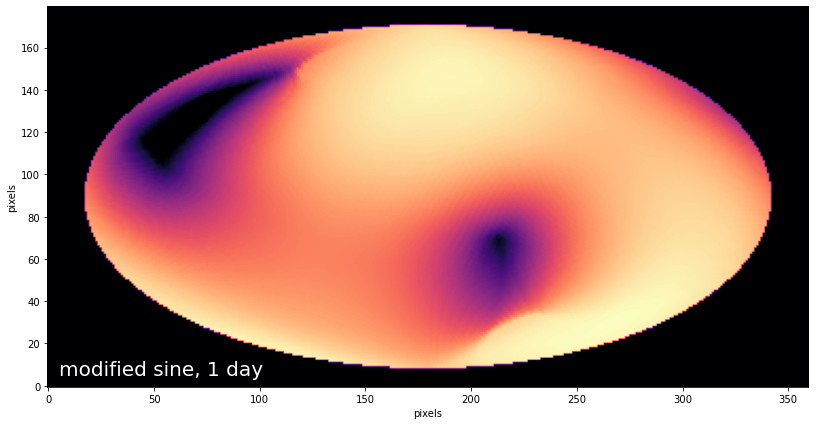

In [25]:
# Plot the One-day Sine map

f1, ax1 = plt.subplots(figsize=(16, 7))
plt.imshow(expcube_hdu_day_sine[0].data[0], 
           cmap='magma',origin='lower',
           vmin=expcube_hdu_day_sine[0].data[0].min(), 
           vmax=expcube_hdu_day_sine[0].data[0].max(),
           norm=colors.PowerNorm(gamma=0.4))
plt.xlabel('pixels')
plt.ylabel('pixels')
label =  "{:.2f} MeV, 1 day".format(expcube_hdu_day_sine[1].data['Energy'][0])
label =  "modified sine, 1 day"
plt.text(5,5,label,fontsize=20, color='white')

This is the map of the sky after one day of exposure with the 50 degree sine profile.

The spots on the exposure map where there is no data correspond to the location of the sun and the antisolar point. In this mode, the blind spots precess with each orbit, so full exposure of the sky is achieved within a week.

Text(5, 5, '+/- 50 rocking, 1 day')

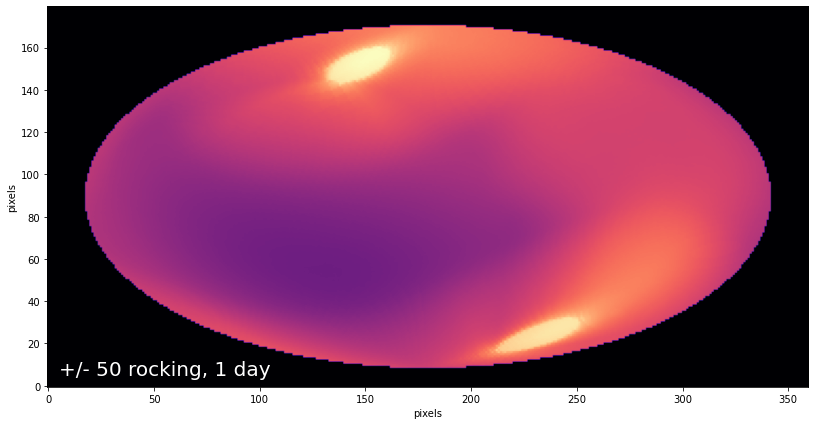

In [26]:
# Plot the all-sky map

f3, ax3 = plt.subplots(figsize=(16, 7))
plt.imshow(expcube_hdu_day_pm50[0].data[0], 
           cmap='magma',origin='lower',
           vmin=expcube_hdu_day_pm50[0].data[0].min(), 
           vmax=expcube_hdu_day_pm50[0].data[0].max())
plt.xlabel('pixels')
plt.ylabel('pixels')
label =  "{:.2f} MeV, 1 orbit".format(expcube_hdu_day_pm50[1].data['Energy'][0])
label =  "+/- 50 rocking, 1 day"
plt.text(5,5,label,fontsize=20, color='white')

This is the map of the sky after one day of exposure with the +/- 50 degree rocking profile.

Here, we notice two bright sections. The field of view of the LAT is quite large; this results in the LAT always detecting photons from the north and south poles of the spacecraft during this survey profile, and those two bright spots are the results of the observations.

In [27]:
expcube_hdu_day_sine[0].data[0].max()

207842060.0

The modified sine profile has a few zero spots where the detector did not detect any events in the sky. This may be due to the observatory being unable to survey those parts of the sky in the given time cut.

The `pm50` expmap maps the full sky; this can be advantageous to us for selecting part of the fits file where there is *only* sky. If we pick the part of the sky where there is an event, we can find the exposure of the sky without the contribution of the invalid parts of the image.

In [28]:
# This expmap fully covers the sky, so the zero values can be used to make a selection of the
# valid (i.e. filled) parts of the expmap. It is in aitoff projection.

expcube_hdu_all = pyfits.open('./data/photon_filtered_pm50_expmap.fits')
selection = expcube_hdu_all[0].data[0]>0 # True for valid part of aitoff projection, false otherwise

This is the difference between using the entire exposure map versus using only the selection where valid data exists:

In [29]:
print(np.double(expcube_hdu_day_sine[0].data[0].mean()))
print(np.double(expcube_hdu_day_sine[0].data[0][selection].mean()))

72660472.0
114137464.0


We can also see what the nonzero values are. These values are stored in your current working directory by running the code cell below.

In [30]:
with open('./data/mod_sine.txt', 'w') as f:
    for item in expcube_hdu_day_sine[0].data[0][selection]:
        f.write("%s\n" % np.double(item))

Now we move onto defining what exposure means and apply it to our maps.

For this purpose, we assume that we have exposure on a certain part of the sky/pixel if the value of that pixel is *greater than half of the mean*.

In [32]:
import numpy as np

# Use selection to pick out the nonzero pixels of all-sky map:
nonzero = expcube_hdu_all[0].data[0][selection] > 0
nonzero_day_pm50 = expcube_hdu_day_pm50[0].data[0][selection] > expcube_hdu_day_pm50[0].data[0][selection].mean() *0.5

print('Number of pixels (pm50):',np.count_nonzero(nonzero))
print('Number of exposed pixels (pm50):',np.count_nonzero(nonzero_day_pm50))

Number of pixels (pm50): 41252
Number of exposed pixels (pm50): 41252


Evidently, the +/- 50 degree profile has exposure in all pixels, so we can use that map as a reference for our sine map.

Now that we have the number of pixels in our all-sky map projection, we can calculate the exposure on the sine profile.

In [33]:
# Use selection to pick out the nonzero pixels of sine map AND find exposed pixels:
nonzero_day_sine = expcube_hdu_day_sine[0].data[0][selection] > expcube_hdu_day_sine[0].data[0][selection].mean() *0.5

print('Number of exposed pixels (sine):', np.count_nonzero(nonzero_day_sine))
print('Number of exposed pixels (pm50):', np.count_nonzero(nonzero_day_pm50))

Number of exposed pixels (sine): 33602
Number of exposed pixels (pm50): 41252


In [34]:
# Fraction of sky pixels exposed

print('Fraction sky exposed (sine): ' + repr(float(np.count_nonzero(nonzero_day_sine))/float(np.count_nonzero(nonzero))))
print('Fraction sky exposed (pm50): ' + repr(float(np.count_nonzero(nonzero_day_pm50))/float(np.count_nonzero(nonzero))))

Fraction sky exposed (sine): 0.81455444584505
Fraction sky exposed (pm50): 1.0


Here, we said that a pixel that was "more than half of the mean" is an exposed pixel. We divided this number by the total number of valid pixels in the map to find the fraction of the sky exposed. As expected, the sky map that we used as a reference was fully exposed. The sine map was about 81% exposed.